# Simulated Based Inference of  BOLD by Generic Hopf model 

### Set up

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
from numba import jit
import scipy as scp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import glob, tqdm
from scipy.stats import multivariate_normal

In [3]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer


from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, DirectPosterior, MCMCPosterior, VIPosterior

from sbi.analysis import pairplot
import sbi.utils as utils

In [4]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [5]:
from FCD import extract_FCD

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [9]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on sbi: v0.18.0


In [10]:
sns.set(style="white")
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [11]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI_GenericSC'

In [12]:
import warnings
np.seterr(all = 'ignore')
warnings.filterwarnings("ignore")

In [13]:
Res_dir='Res_SBI_BNM_GenericHopf_GenericSCavgn_InferG_MomentsFCFCD_savesim1k_v18'

# Gnerate the Human Connectome

In [14]:
weights = np.load('connectomes/hcp-100.npz')['weights']
weights += weights.transpose((0, 2, 1))
#weights = np.log(1 + weights)
weights.shape

(100, 84, 84)

In [15]:
weights.shape, weights.min(), weights.max()

((100, 84, 84), 0.0, 16842.0)

In [16]:
ns=weights.shape[0]
nn=weights[0,:,:].shape[0]

ns, nn

(100, 84)

In [17]:
SCs=np.zeros((ns, nn, nn))

In [18]:
for i in range(100):
    SCs[i,:,:]=weights[i,:,:]/np.max(weights[i,:,:])

In [19]:
SCs[0,:,:].shape, SCs[0,:,:].min(), SCs[0,:,:].max()

((84, 84), 0.0, 1.0)

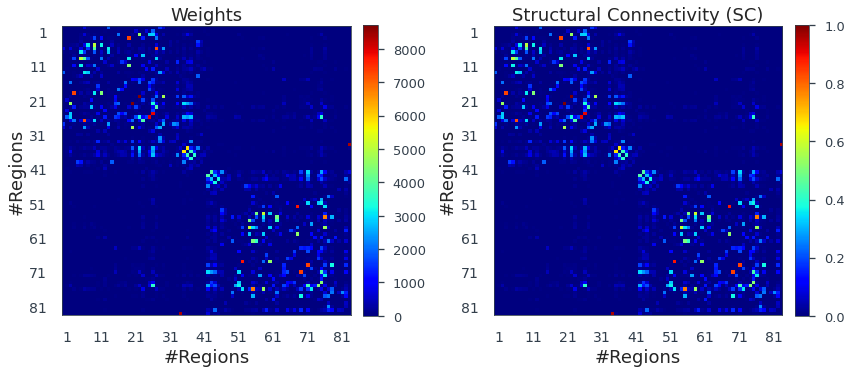

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((weights[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Weights', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
plt.imshow((SCs[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC0.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC0.eps"), doi=800)
plt.show()

In [21]:
w_ = SCs.reshape((ns, -1))
u, s, vt = np.linalg.svd(w_, full_matrices=False)
u.shape, vt.shape

((100, 100), (100, 7056))

In [22]:
for nc in range(2, 20):
    rSCs = (u[:,:nc] @ np.diag(s[:nc]) @ vt[:nc]).reshape(SCs.shape)
    sim = np.zeros((100, 100))
    nconf = 0
    for i in range(100):
        for j in range(100):
            sim[i,j] = np.sum(np.square(rSCs[i] - SCs[j]))
        nconf  += int(np.argmin(sim[i,:])!=i)
    print('components', nc, 'confusions', nconf)
    if nconf == 0:
        break

components 2 confusions 86
components 3 confusions 78
components 4 confusions 67
components 5 confusions 56
components 6 confusions 43
components 7 confusions 38
components 8 confusions 23
components 9 confusions 15
components 10 confusions 9
components 11 confusions 5
components 12 confusions 3
components 13 confusions 2
components 14 confusions 0


In [23]:
mu_true = np.mean(u[:,:nc], axis=0)
cov_true = np.cov(u[:,:nc].T)
mu_true.shape, cov_true.shape

((14,), (14, 14))

In [24]:
n_compt=mu_true.shape[0]
n_compt

14

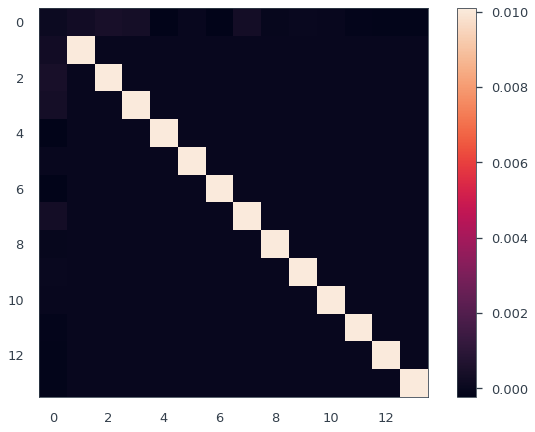

In [25]:
imshow(cov_true), colorbar();

In [26]:
mu_true

array([-9.93781281e-02,  2.69891750e-03,  4.25692302e-03,  3.64258853e-03,
       -2.25661604e-03,  9.07329344e-05, -2.09537568e-03,  3.11153264e-03,
       -5.76778179e-04,  5.56056042e-04,  1.48810206e-04, -1.10536904e-03,
       -1.54286817e-03, -1.72020698e-03])

In [27]:
mu_true.min(), mu_true.max()

(-0.09937812810938823, 0.004256923019221633)

In [28]:
from scipy.stats import multivariate_normal
dist = multivariate_normal(mean=mu_true, cov=cov_true)
new_u = dist.rvs(size=(ns,))
new_u.shape

(100, 14)

In [29]:
new_SCs = (new_u @ np.diag(s[:nc]) @ vt[:nc]).reshape(SCs.shape)

In [30]:
new_SCs.shape, new_SCs.min(), new_SCs.max()

((100, 84, 84), -0.015954817725451338, 1.2857813320289444)

In [31]:
new_SCs_avg=np.mean(new_SCs, axis=0)

In [32]:
new_SCs_avg.shape, new_SCs_avg.min(), new_SCs_avg.max()

((84, 84), -6.264598948870759e-08, 0.9037523934924464)

In [33]:
new_SCs_avg_n=(new_SCs_avg-np.min(new_SCs_avg))/(np.max(new_SCs_avg)-np.min(new_SCs_avg))

In [34]:
new_SCs_avg_n.shape, new_SCs_avg_n.min(),new_SCs_avg_n.max()

((84, 84), 0.0, 1.0)

In [35]:
SC_true_avg_n=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/SC_true_avg_n.npy')

In [36]:
sum((new_SCs_avg_n-SC_true_avg_n))

-0.4687194559672319

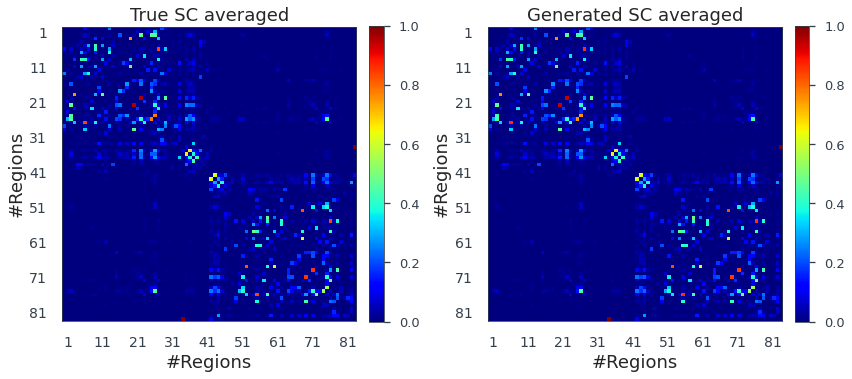

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC_true_avg_n), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('True SC averaged', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
plt.imshow((new_SCs_avg_n), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Generated SC averaged', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_generated.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC_generated.eps"), doi=800)
plt.show()

### constants

In [38]:
eta_c=0       
delta_eta=.5                  
prior_std =1.0
sd_thr=0.5

# whole-brain network simulation

$  \frac{d x_i}{dt}= (\eta_i-x_i^2-y_i^2)x_i -\omega_i y_i+ G \sum_{j=1}^{N} C_{j,i} ( x_j- x_i) +\sigma \xi_i(t)$

$ \frac{d y_i}{dt}= (\eta_i-x_i^2-y_i^2)y_i +\omega_i x_i + G \sum_{j=1}^{N} C_{j,i} ( y_j- y_i)+ \sigma \xi_i(t)$


In [39]:
from GenericHopfModel import GenericHopfBOLD

In [40]:
from GenericHopfModel_features import calculate_summary_statistics

In [41]:
@jit(nopython=False)
def GenericHopf_simulator_wrapper(params):
    
    params = np.asarray(params)
    
    ## fixed values: simulation time lenght (T), the time step (dt), the array of time points (ts),  
    ##  noise level (sigma), time step for BalloonWindkessel, downsampling (ds). 
    
    nn=84
    ns=100
    
    Tmax = 120.0
    dt=0.001
    ts = np.arange(0, Tmax + dt, dt)
    sigma=1e-1
    dt_bold=0.001
    ds=180


    ## initial conditions
    x_init=0
    y_init=0
    init_conditions = np.array([x_init, y_init])

    ##param : global coupling parameter (G)
    params_G=params[0]
    params_mu=params[1:]
    dist = multivariate_normal(mean=params_mu, cov=cov_true)
    new_u = dist.rvs(size=(ns,))
    
    new_SCs = (new_u @ np.diag(s[:nc]) @ vt[:nc]).reshape(SCs.shape)
    new_SCs_avg=np.mean(new_SCs, axis=0)
    new_SCs_avg_n=(new_SCs_avg-np.min(new_SCs_avg))/(np.max(new_SCs_avg)-np.min(new_SCs_avg))

    Simulated_BOLD = GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, params_G, new_SCs_avg_n,  dt, dt_bold, Tmax, ds)

#     print('G=',params_G)
#     BOLD_sanity=Simulated_BOLD.reshape(nn, int(Simulated_BOLD.shape[0]/nn))
#     plt.figure(figsize=(10, 3))
#     plt.plot(BOLD_sanity.T, lw=1)
#     plt.show()
    
 #   summstats = torch.as_tensor(calculate_summary_statistics(Simulated_BOLD, nn, features=['moments', 'FC_corr', 'FCD_corr']))

    return Simulated_BOLD 

### some simulations for  sanity check

In [42]:
Tmax = 120.0
dt=0.001
ts = np.arange(0, Tmax + dt, dt)
sigma=1e-1
dt_bold=0.001
ds=180

In [43]:
nt=ts.shape[0]
nt_bold=int(nt/ds)
nt, nt_bold

(120001, 666)

In [44]:
SC=new_SCs_avg_n
nn=SC.shape[0]
nn

84

In [45]:
## Constant values: the intrinsic frequency generated randomly between [0.02-0.04] HZ 
omega_true=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/omega_true.npy')
omega_true.shape

(84,)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


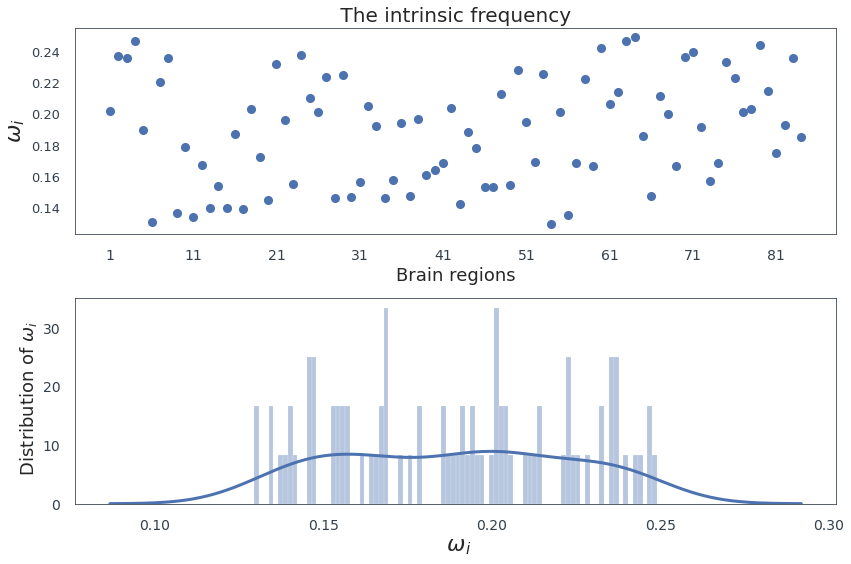

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(omega_true, 'bo')
plt.title(' The intrinsic frequency ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\omega_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(212)
prior_plot=sns.distplot(omega_true, bins=84,hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\omega_i$',fontsize=18)
plt.xlabel(' $\omega_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Omega_true.eps"), doi=800)
plt.show()

In [47]:
eta_true=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/eta_true.npy')
eta_true.shape

(84,)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


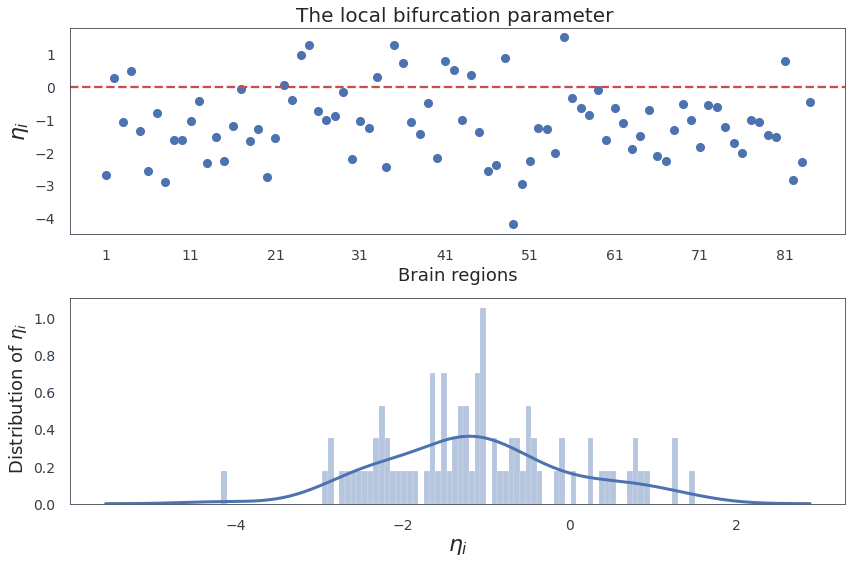

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(211)

plt.plot(eta_true, 'bo')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('The local bifurcation parameter ',fontsize=20)
plt.xlabel('Brain regions',fontsize=18)
plt.ylabel('$\eta_i$',fontsize=22)
plt.xticks(np.r_[0:nn][::10], np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
#plt.hist(eta_true, bins=84);
prior_plot=sns.distplot(eta_true, bins=84, hist=True, kde=True, color="b", kde_kws=dict(linewidth=3))
plt.ylabel(' Distribution of $\eta_i$',fontsize=18)
plt.xlabel('$\eta_i$',fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Eta_true.eps"), doi=800)
plt.show()

In [49]:
## initial conditions
x_init=0
y_init=0
init_conditions = np.array([x_init, y_init])

In [50]:
G_true=0.2

### Run Sanity check with JIT

In [51]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, new_SCs_avg_n,  dt, dt_bold, Tmax, ds)

print(" one simulation (sec) takes:" , (time.time() - start_time))

 one simulation (sec) takes: 5.427868604660034


In [52]:
start_time = time.time()

BOLD_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_true, new_SCs_avg_n,  dt, dt_bold, Tmax, ds)

print(" one JIT simulation  (sec) takes:" , (time.time() - start_time))

 one JIT simulation  (sec) takes: 3.726602792739868


In [53]:
BOLD_.shape

(56028,)

In [54]:
BOLD_sanity=BOLD_.reshape(nn, int(BOLD_.shape[0]/nn))

BOLD_sanity.shape

(84, 667)

In [55]:
np.save(os.path.join(Res_dir, 'Sim_BOLD_GeneratedSCavgn_GenericHopf_G_'+str(G_true)+'.npy') , BOLD_sanity)

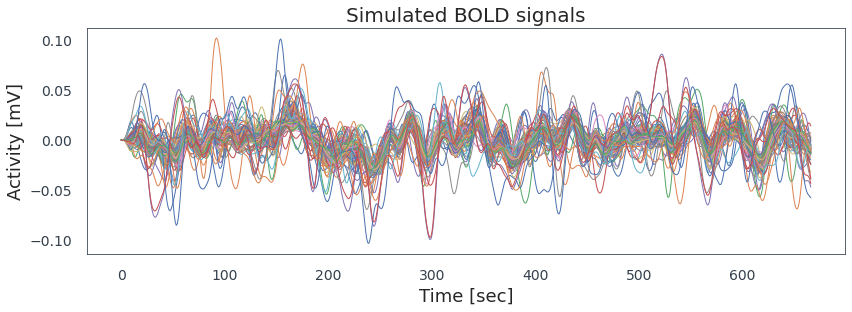

In [56]:
plt.figure(figsize=(12,4.5))
plt.plot(BOLD_sanity.T, lw=1)
plt.title("Simulated BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity.eps"), doi=800)
plt.show()

In [57]:
FCcorr=np.corrcoef(BOLD_sanity)
FCcorr.shape

(84, 84)

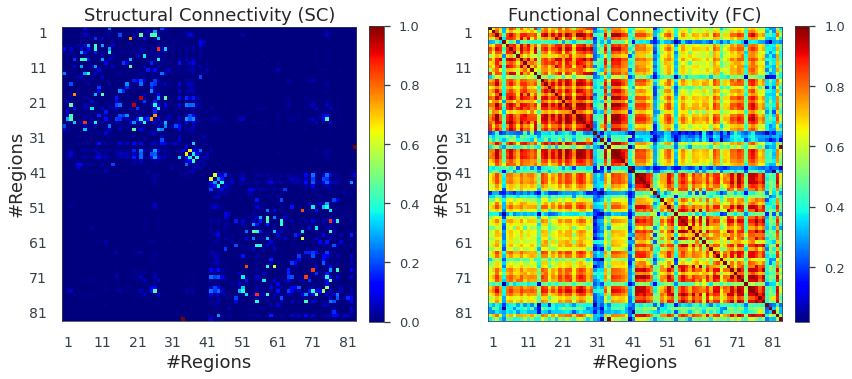

In [58]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SC), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Functional Connectivity (FC)', fontsize=18.0)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_SCFC.eps"), doi=800)
plt.show()

In [59]:
wwidth=30
maxNwindows=200
olap=0.94

In [60]:
FCDcorr,Pcorr,shift=extract_FCD(BOLD_sanity,wwidth,maxNwindows,olap,mode='corr')
FCDcorr.shape

(207, 207)

In [61]:
FCDcorr.var(), FCDcorr.sum(), 

(0.029938733289068778, 16499.59698117643)

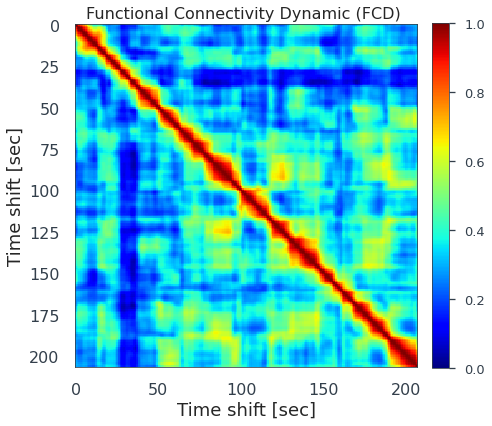

In [62]:
plt.figure(figsize=(7, 7))
plt.imshow(FCDcorr, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Functional Connectivity Dynamic (FCD) ', fontsize=16)
plt.ylabel('Time shift [sec]', fontsize=18.0)
plt.xlabel('Time shift [sec]', fontsize=18.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FCD.eps"), doi=800)
plt.show()

In [63]:
_=calculate_summary_statistics(BOLD_, nn, features=['moments', 'FC_corr', 'FCD_corr'])
print('feature shape:', _.shape)

feature shape: (498,)


### 2. Prior over model parameters

Here we provide a plausible ranges for the parameters that we aim to infer, by placing a uniform prior on them.

In [64]:
prior_min_G=0.0*np.ones(1)

prior_max_G=1.0*np.ones(1)

In [65]:
mu_true.min(), mu_true.max()

(-0.09937812810938823, 0.004256923019221633)

In [66]:
prior_min_mu=-0.11*np.ones(n_compt)

prior_max_mu=0.005*np.ones(n_compt)

In [67]:
prior_min=np.hstack([prior_min_G, prior_min_mu])
prior_max=np.hstack([prior_max_G, prior_max_mu])

In [68]:
prior_min.shape, prior_max.shape

((15,), (15,))

In [69]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [70]:
prior.sample()

tensor([ 0.6994, -0.0349, -0.0921, -0.0027, -0.0880, -0.0707,  0.0008, -0.0831,
        -0.0414, -0.0170, -0.0719, -0.1050, -0.0880, -0.0108, -0.0095])

In [71]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 15


### Save simulations

In [72]:
num_sim=1000

In [73]:
try:
    os.mkdir(Res_dir+'/output_simulations')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [74]:
mysavepath = os.path.join(Res_dir, 'output_simulations/simulated_theta_x_GenericHopf.npz')
mysavepath

'Res_SBI_BNM_GenericHopf_GenericSCavgn_InferG_MomentsFCFCD_savesim1k_v18/output_simulations/simulated_theta_x_GenericHopf.npz'

In [75]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

In [76]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 15])
data shape: torch.Size([1, 56028])
------------------------------------------------------------
--- one simulation took: 9.195508480072021 seconds ---


In [77]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one simulation with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 15])
data shape: torch.Size([1, 56028])
------------------------------------------------------------
--- one simulation with JIT took: 6.565221071243286 seconds ---


In [78]:
start_time = time.time()

Save_simulations(GenericHopf_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

theta shape: torch.Size([1000, 15])
data shape: torch.Size([1000, 56028])
------------------------------------------------------------
---all simulations took:  3716.1794669628143 seconds ---


### Load simulations and calculate features

In [79]:
loaded_simulations=np.load(mysavepath)

In [80]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [81]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (1000, 15)
data shape: (1000, 56028)


In [82]:
if np.isfinite(np.sum(x_sim[0,:]))==True:
    _=calculate_summary_statistics(x_sim[0,:], nn, features=['moments', 'FC_corr', 'FCD_corr'])
    _.shape

num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 498


In [83]:
theta_features=np.zeros((num_sim,num_params) , dtype='float32')
x_features=np.zeros((num_sim,num_features), dtype='float32')

In [84]:
print( 'theta shape:',theta_features.shape,flush=True)
print('data frature shape:', x_features.shape,flush=True)

theta shape: (1000, 15)
data frature shape: (1000, 498)


In [85]:
start_time = time.time()

i = 0
for i in range(num_sim):
       if np.isfinite(np.sum(x_sim[i,:]))==True:
              theta_features[i,:]=theta_sim[i,:] 
              x_features[i,:]=calculate_summary_statistics(x_sim[i,:], nn, features=['moments', 'FC_corr', 'FCD_corr'])
       i += 1
    
print ("-"*60)
print("--- Calculating features took: %s seconds ---" % (time.time() - start_time))    

------------------------------------------------------------
--- Calculating features took: 184.02069687843323 seconds ---


In [86]:
theta_features.shape, x_features.shape, print(theta_features.dtype)


float32


((1000, 15), (1000, 498), None)

In [87]:
index = np.isnan(x_sim).any(axis=1)
np.count_nonzero(index)

46

In [88]:
x_features = np.delete(x_features, index, axis=0)
theta_features=np.delete(theta_features, index, axis=0)

In [89]:
theta_features.shape, x_features.shape, print(theta_features.dtype)

float32


((954, 15), (954, 498), None)

In [90]:
theta_features.shape, x_features.shape, print(theta_features.dtype)

float32


((954, 15), (954, 498), None)

In [91]:
 print(theta_features.dtype)

float32


In [92]:
x = np.array(x_features, dtype='float32')
x = torch.as_tensor(x)

theta = np.array(theta_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [93]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([954, 15])
data feature shape: torch.Size([954, 498])


In [94]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([954, 15])
data feature shape: torch.Size([954, 498])


In [95]:
numpy.isnan(x).any()

tensor(0, dtype=torch.uint8)

In [96]:
numpy.isfinite(x).all()

tensor(1, dtype=torch.uint8)

### 3. Inference

Finally we use Sequential Neural Posterior Estimation (SNPE) to sample from the posterior $p(\theta|x)$. The inputs are prior, parameter theta and (the data features of) observation x, and it returns us the posterior $p(\theta|x)$.

In [97]:
# posterior = infer(GenericHopf_simulator_wrapper, prior, method='SNPE', num_simulations=100, num_workers=1)

In [98]:
inference = SNPE(prior, density_estimator='maf', device='cpu')

In [99]:
start_time = time.time()

posterior_estimator = inference.append_simulations(theta, x).train()

print ("-"*60)
print("---training took:  %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 45 epochs.------------------------------------------------------------
---training took:  7.106502532958984 seconds ---


In [100]:
## Without the saving and loading simulations, we can run sbi using the default function "infer", as follows:
##posterior = infer(GenericHopf_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

### Observed data set I (optimal G)

After the training NN, the posterior is amortized (i.e., no need to again train the neural network) and by providing the features of observation (empirical or simulated with same dimension as we used for training), we are able to efficiently obtain the posterior of parameters.

In the following we use different ground-truth values for simulation to validate the inference.

In [101]:
G_true=0.25

In [102]:
BOLD_obs=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy')

In [103]:
obs_bold_features=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [104]:
obs_bold_features.max()

15448.880687397424

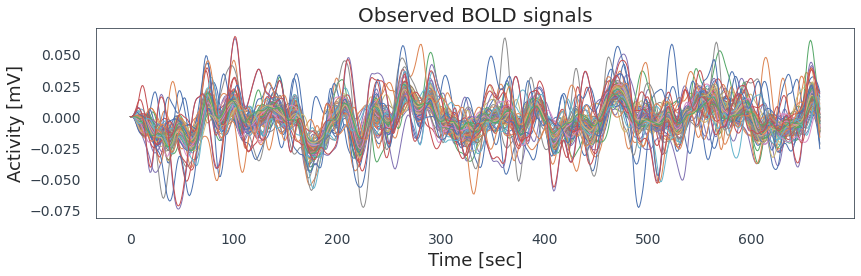

In [105]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs1.eps"), doi=800)
plt.show()

In [106]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [107]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

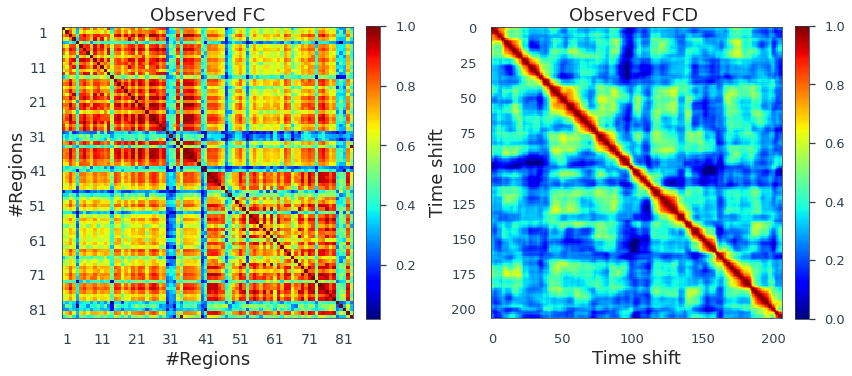

In [108]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs1.eps"), doi=800)
plt.show()

### Posterior of G for  data set I

In [109]:
labels_params = [r'$G$']

In [110]:
num_samples=2000

In [111]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [112]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.5636451244354248


In [113]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs1.npy') , posterior_samples)

In [114]:
posterior_samples.shape, 

((2000, 15),)

In [115]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.09254661, -0.10490358, -0.09317162, -0.09874952, -0.09754   ,
        -0.09980867, -0.09897724, -0.09429859, -0.09582308, -0.096336  ,
        -0.0981508 , -0.09520132, -0.09612388, -0.09829871, -0.09987839],
       [ 0.23223725, -0.07774616, -0.00291882, -0.00505326, -0.00768561,
        -0.00773917, -0.00975465, -0.01044247, -0.00899605, -0.00563784,
        -0.00766331, -0.00537796, -0.00568851, -0.00849975, -0.0087098 ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


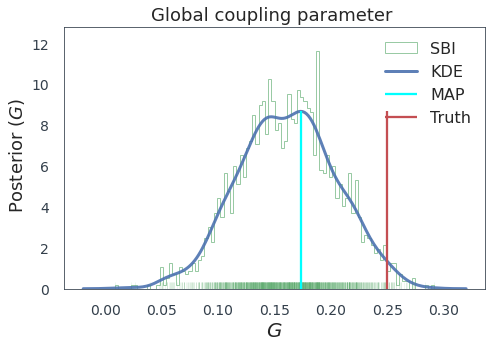

In [116]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')


x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs1.eps"), doi=800)
plt.show()

In [117]:
G_posterior.mean(), G_true

(0.16148093, 0.25)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


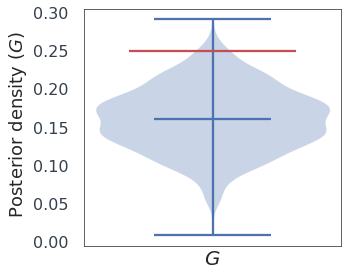

In [118]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs1.eps"), doi=800)
plt.show()

In [119]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.09254661, -0.10490358, -0.09317162, -0.09874952, -0.09754   ,
        -0.09980867, -0.09897724, -0.09429859, -0.09582308, -0.096336  ,
        -0.0981508 , -0.09520132, -0.09612388, -0.09829871, -0.09987839],
       [ 0.23223725, -0.07774616, -0.00291882, -0.00505326, -0.00768561,
        -0.00773917, -0.00975465, -0.01044247, -0.00899605, -0.00563784,
        -0.00766331, -0.00537796, -0.00568851, -0.00849975, -0.0087098 ]])

In [120]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [121]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [122]:
np.save(os.path.join(Res_dir, 'BOLD_obs1.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit1.npy') , BOLD_fit)

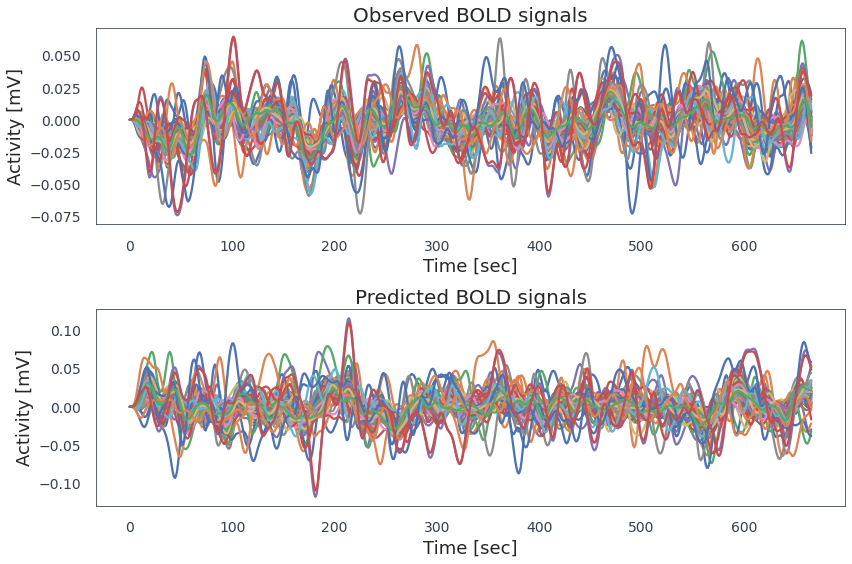

In [123]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs1.eps"), doi=800)
plt.show()

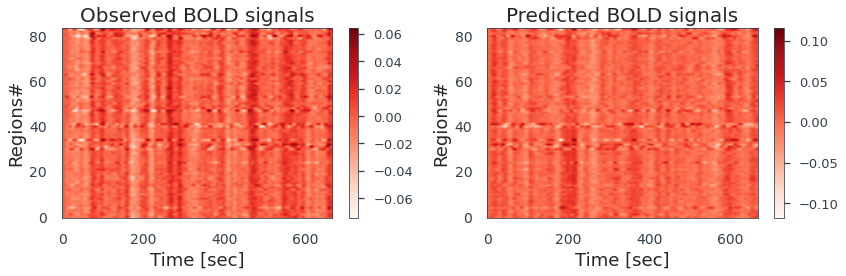

In [124]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs1.eps"), doi=800)
plt.show()

In [125]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

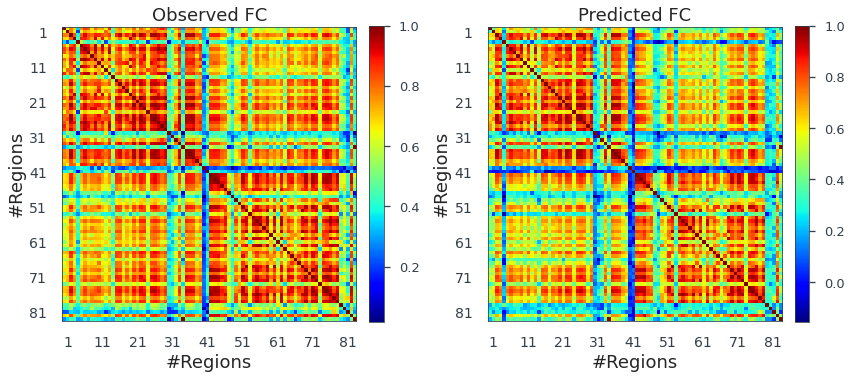

In [126]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs1.eps"), doi=800)
plt.show()

In [127]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

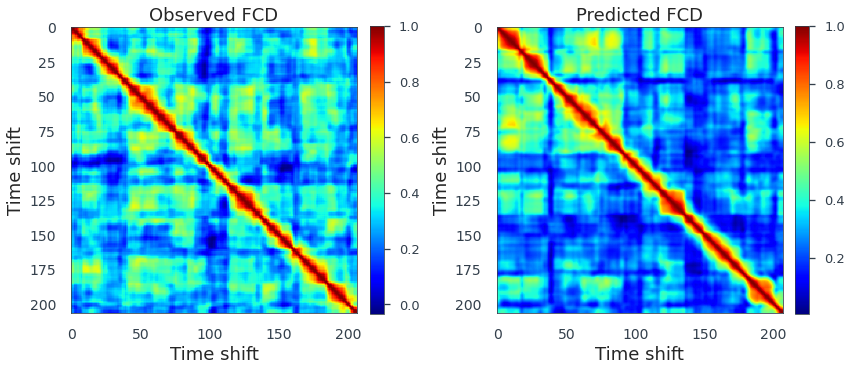

In [128]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs1.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


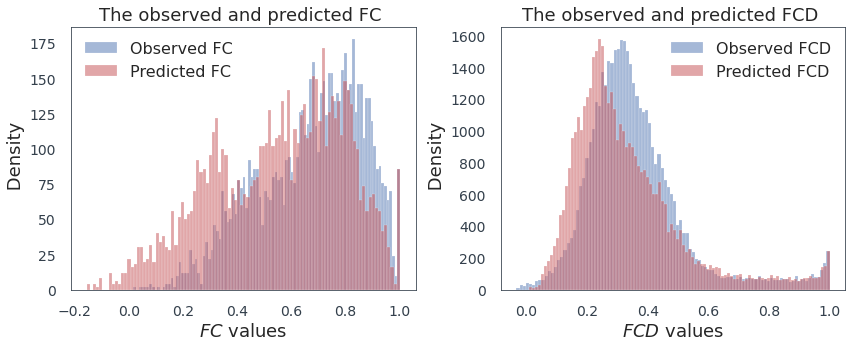

In [129]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs1.eps"), doi=800)
plt.show()

In [130]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(56.38491596519117, 46.5308436782643)

In [131]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(183.91524627854076, 170.46613888899986)

In [132]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [133]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(nan, nan)

In [134]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [135]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.0316005274722306

In [136]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.07988726076319387

In [137]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.15748325515181222, pvalue=0.0)

# Another data set

### Observed data set II (low G)

In [138]:
G_true=0.1

In [139]:
BOLD_obs=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy')

In [140]:
obs_bold_features=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [141]:
obs_bold_features.max()

9890.249110874793

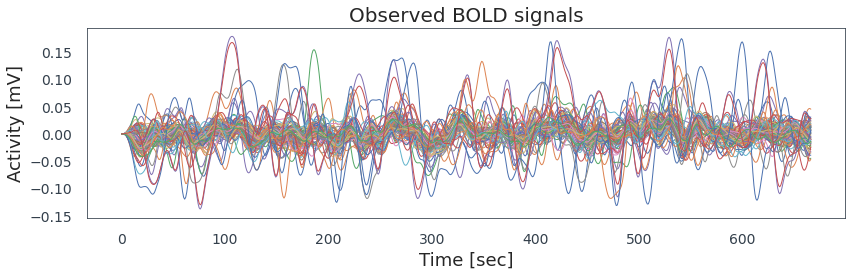

In [142]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs2.eps"), doi=800)
plt.show()

In [143]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [144]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

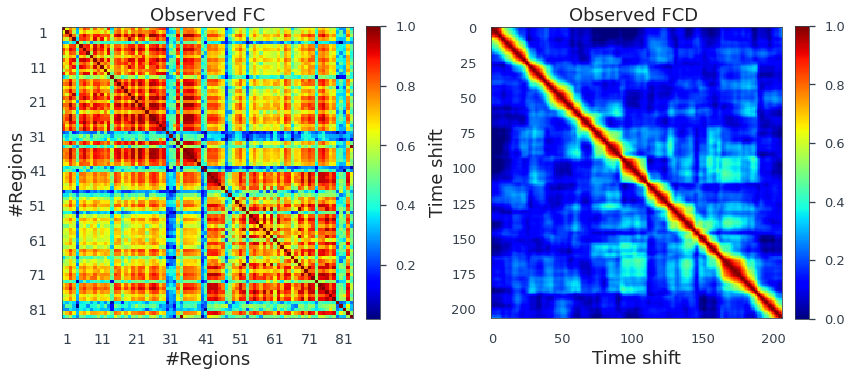

In [145]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs2.eps"), doi=800)
plt.show()

### Posterior of G for  data set II

In [146]:
labels_params = [r'$G$']

In [147]:
num_samples=2000

In [148]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [149]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.5616898536682129


In [150]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs2.npy') , posterior_samples)

In [151]:
posterior_samples.shape,

((2000, 15),)

In [152]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.06992347, -0.1081929 , -0.09183746, -0.0992607 , -0.09949786,
        -0.09577998, -0.09693766, -0.09516134, -0.08937872, -0.09669974,
        -0.09197893, -0.09200193, -0.09126094, -0.09857944, -0.09982892],
       [ 0.20489397, -0.08069331, -0.0081824 , -0.0052363 , -0.00673715,
        -0.0048921 , -0.00974212, -0.00971515, -0.00657677, -0.00863272,
        -0.006117  , -0.00520922, -0.00551   , -0.00872154, -0.01182815]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


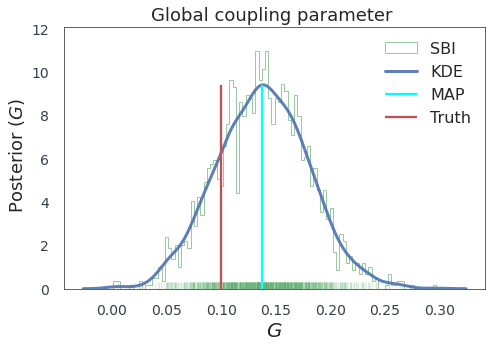

In [153]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs2.eps"), doi=800)
plt.show()

In [154]:
G_posterior.mean(), G_true

(0.13786334, 0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


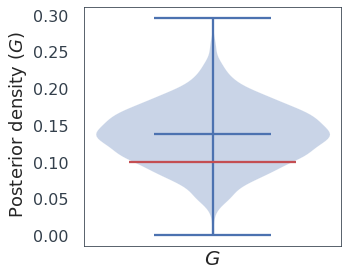

In [155]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs2.eps"), doi=800)
plt.show()

In [156]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.06992347, -0.1081929 , -0.09183746, -0.0992607 , -0.09949786,
        -0.09577998, -0.09693766, -0.09516134, -0.08937872, -0.09669974,
        -0.09197893, -0.09200193, -0.09126094, -0.09857944, -0.09982892],
       [ 0.20489397, -0.08069331, -0.0081824 , -0.0052363 , -0.00673715,
        -0.0048921 , -0.00974212, -0.00971515, -0.00657677, -0.00863272,
        -0.006117  , -0.00520922, -0.00551   , -0.00872154, -0.01182815]])

In [157]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [158]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [159]:
np.save(os.path.join(Res_dir, 'BOLD_obs2.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit2.npy') , BOLD_fit)

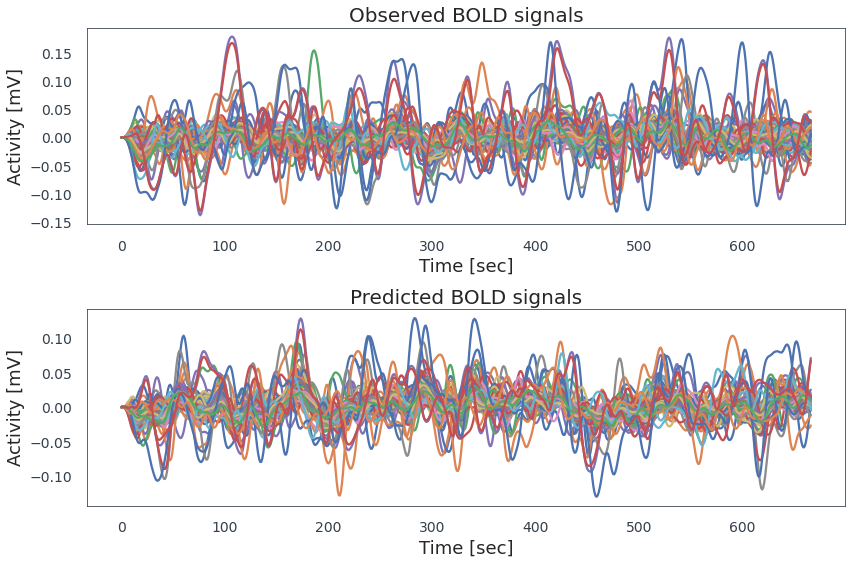

In [160]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs2.eps"), doi=800)
plt.show()

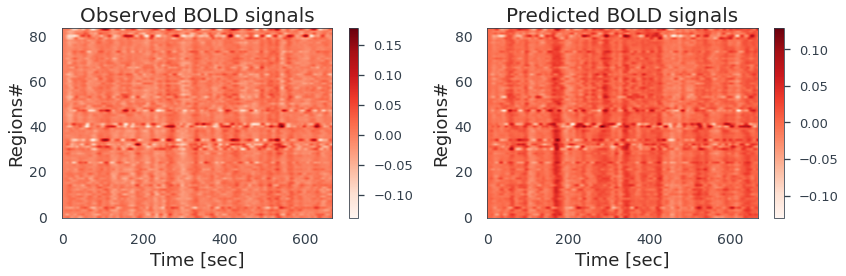

In [161]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs2.eps"), doi=800)
plt.show()

In [162]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

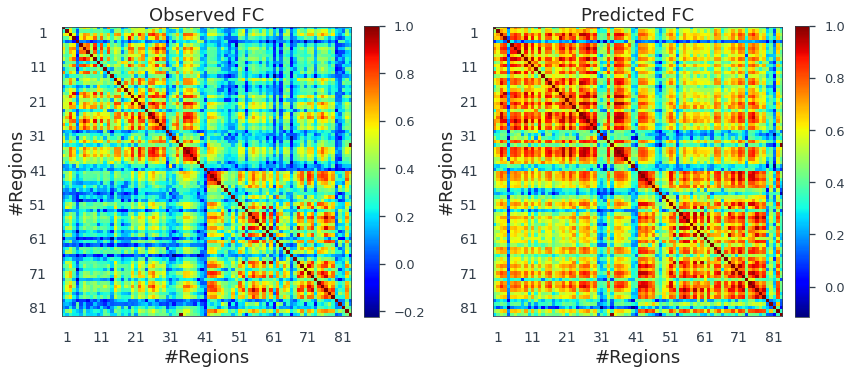

In [163]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs2.eps"), doi=800)
plt.show()

In [164]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

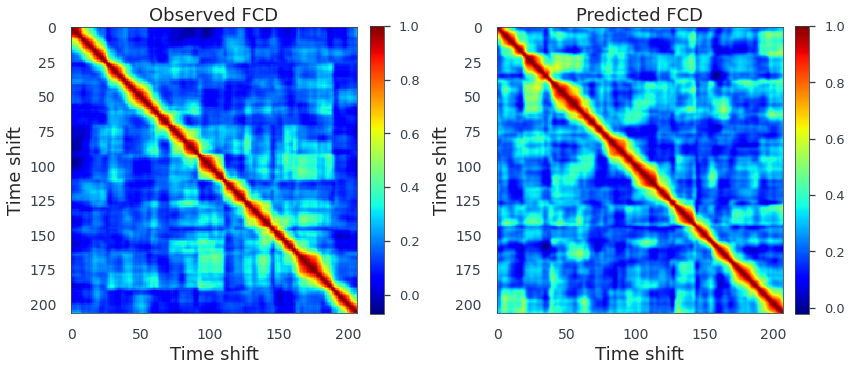

In [165]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs2.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


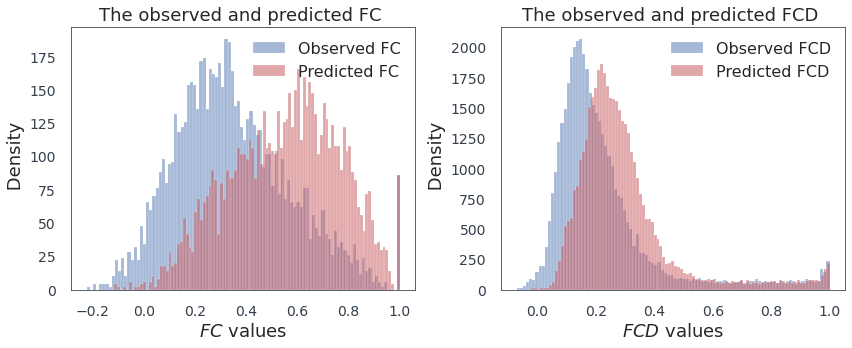

In [166]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs2.eps"), doi=800)
plt.show()

In [167]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(29.350632025115747, 46.29323784674032)

In [168]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(117.74106084374753, 151.1169975780292)

In [169]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [170]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(nan, nan)

In [171]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

nan

In [172]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.06551178827118057

In [173]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.16520333378256075

In [174]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.30567807883497866, pvalue=0.0)

### Observed data set III (hight G)

In [175]:
G_true=0.5

In [176]:
BOLD_obs=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy')

In [177]:
obs_bold_features=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [178]:
obs_bold_features.max()

18934.38187882297

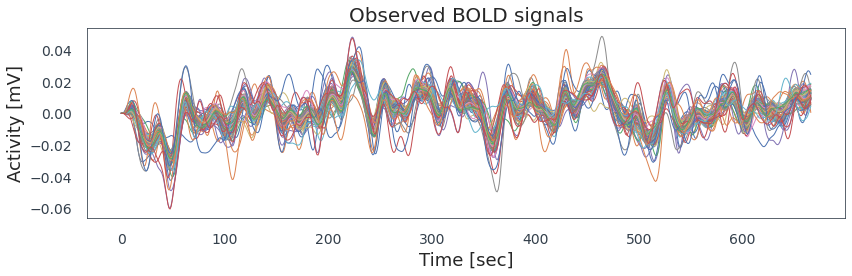

In [179]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs3.eps"), doi=800)
plt.show()

In [180]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [181]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

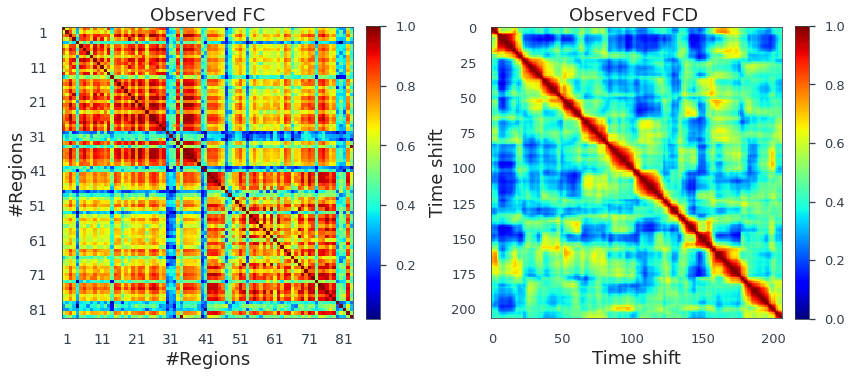

In [182]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs3.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [183]:
labels_params = [r'$G$']

In [184]:
num_samples=2000

In [185]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [186]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.4311549663543701


In [187]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs3.npy') , posterior_samples)

In [188]:
posterior_samples.shape,

((2000, 15),)

In [189]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.35281432, -0.09168248, -0.09329324, -0.09304805, -0.09659921,
        -0.09804839, -0.09361636, -0.09608615, -0.0943225 , -0.09600955,
        -0.09718544, -0.09562491, -0.09633737, -0.09632814, -0.09943325],
       [ 0.50886843, -0.064058  , -0.01002556, -0.00778555, -0.00821077,
        -0.01087643, -0.00924514, -0.01434237, -0.00735465, -0.00630051,
        -0.0061831 , -0.00857267, -0.00369243, -0.00358792, -0.00688828]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


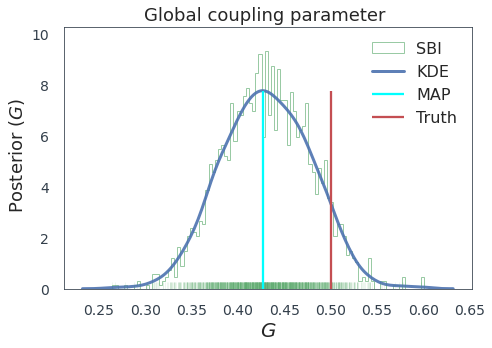

In [190]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs3.eps"), doi=800)
plt.show()

In [191]:
G_posterior.mean(), G_true

(0.43102187, 0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


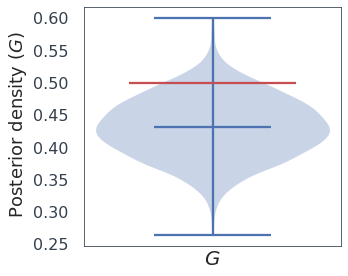

In [192]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs3.eps"), doi=800)
plt.show()

In [193]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.35281432, -0.09168248, -0.09329324, -0.09304805, -0.09659921,
        -0.09804839, -0.09361636, -0.09608615, -0.0943225 , -0.09600955,
        -0.09718544, -0.09562491, -0.09633737, -0.09632814, -0.09943325],
       [ 0.50886843, -0.064058  , -0.01002556, -0.00778555, -0.00821077,
        -0.01087643, -0.00924514, -0.01434237, -0.00735465, -0.00630051,
        -0.0061831 , -0.00857267, -0.00369243, -0.00358792, -0.00688828]])

In [194]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [195]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [196]:
np.save(os.path.join(Res_dir, 'BOLD_obs3.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit3.npy') , BOLD_fit)

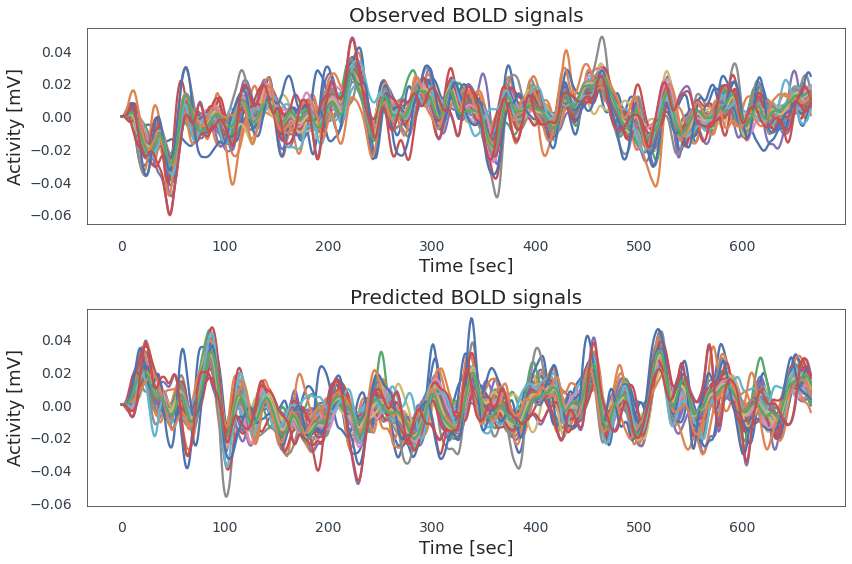

In [197]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs3.eps"), doi=800)
plt.show()

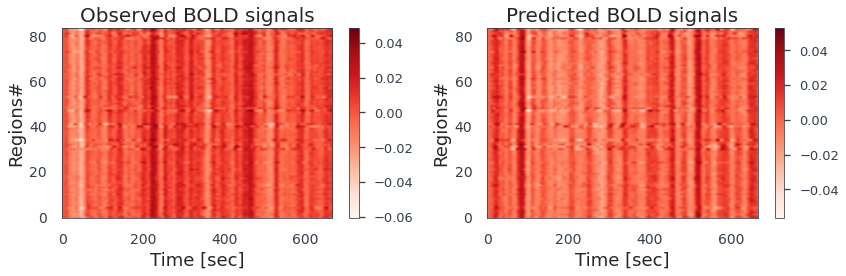

In [198]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs3.eps"), doi=800)
plt.show()

In [199]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

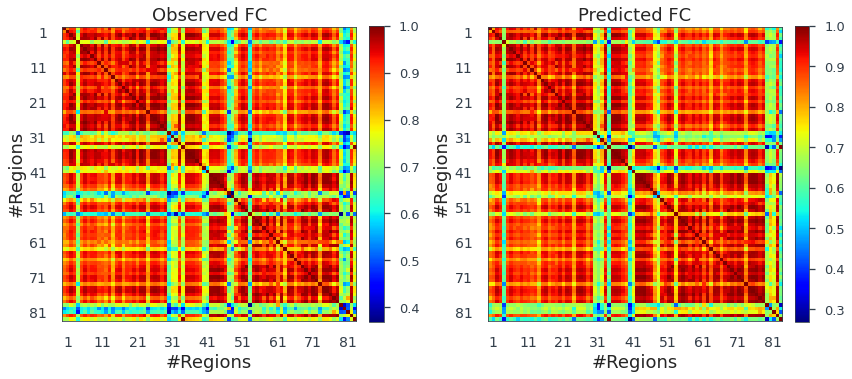

In [200]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs3.eps"), doi=800)
plt.show()

In [201]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

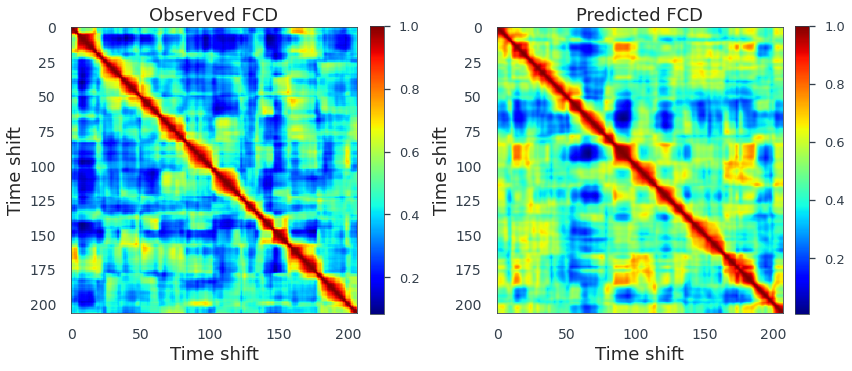

In [202]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs3.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


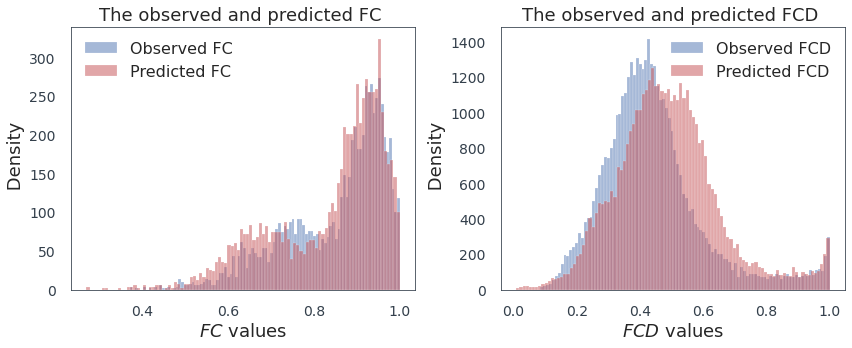

In [203]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs3.eps"), doi=800)
plt.show()

In [204]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(71.33279106887254, 70.15558121666774)

In [205]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(225.40930808122582, 249.4440158119856)

In [206]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [207]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(-338.34374606088494, 3831.9750001221805)

In [208]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

422.8042793862708

In [209]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.048006675382436755

In [210]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.11071861506471732

In [211]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.18268804406170502, pvalue=0.0)

### Observed data set IIII (very hight G)

In [212]:
G_true=0.75

In [213]:
BOLD_obs=np.load('Res_SBI_BNM_GenericHopf_TrueSCavgn_InferG_MomentsFCFCD_savesim1k_v18/Sim_BOLDobserved_TrueSCavgn_GenericHopf_G_'+str(G_true)+'.npy')

In [214]:
obs_bold_features=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, features=['moments', 'FC_corr', 'FCD_corr'])

In [215]:
obs_bold_features.max()

19205.598151178358

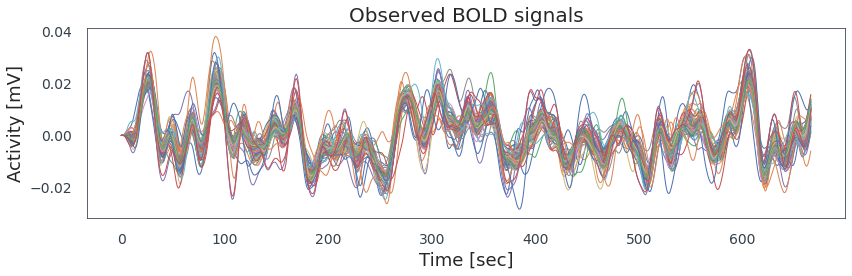

In [216]:
plt.figure(figsize=(12,4))
plt.plot(BOLD_obs.T, lw=1)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_obs4.eps"), doi=800)
plt.show()

In [217]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_obs.shape

(84, 84)

In [218]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')

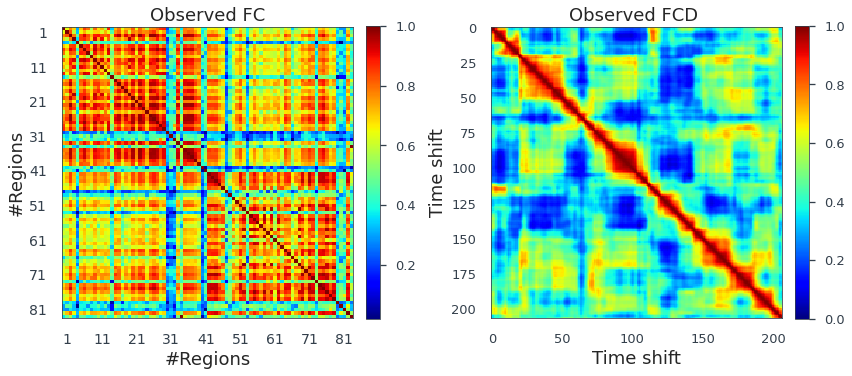

In [219]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
im = plt.imshow(FCcorr,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.subplot(122)
plt.imshow(FCDcorr_obs, vmin=0,vmax=1, interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Observed FCD ', fontsize=18)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SimulatedBOLD_sanity_FC_FCD_obs4.eps"), doi=800)
plt.show()

### Posterior of G for  data set III

In [220]:
labels_params = [r'$G$']

In [221]:
num_samples=2000

In [222]:
posterior = DirectPosterior(posterior_estimator, prior,) 

In [223]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_bold_features).numpy()

print(" Sampling posterior (sec) took:" , (time.time() - start_time))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

 Sampling posterior (sec) took: 0.5101354122161865


In [224]:
np.save(os.path.join(Res_dir, 'posterior_samples_obs4.npy') , posterior_samples)

In [225]:
posterior_samples.shape, 

((2000, 15),)

In [226]:
G_posterior=posterior_samples[:,0]
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.52155615, -0.10222377, -0.10042516, -0.09710639, -0.09738242,
        -0.09830241, -0.09285019, -0.09815911, -0.09340212, -0.10006581,
        -0.09154127, -0.09426099, -0.09639983, -0.0986607 , -0.09222934],
       [ 0.69182441, -0.07204886, -0.00867389, -0.00817059, -0.00863831,
        -0.00612709, -0.00687498, -0.01192491, -0.00883712, -0.00914688,
        -0.0058925 , -0.00950634, -0.00622356, -0.00433986, -0.00760781]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


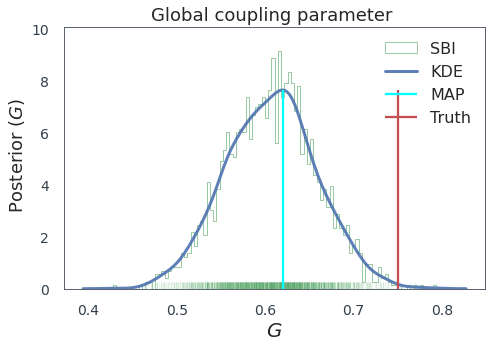

In [227]:
plt.figure(figsize=(7, 5))

#sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, color="b", kde_kws=dict(linewidth=3), label='SBI')
ax=sns.distplot(G_posterior, bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

x_ = ax.lines[0].get_xdata()
y_ = ax.lines[0].get_ydata()
ymax = max(y_)
xpos = np.argmax(y_, axis=0)
xmax = x_[xpos]
plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
plt.vlines(x=G_true, ymin=0., ymax=y_.max(), colors='r', label='Truth')

plt.title('Global coupling parameter ',fontsize=18)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs4.eps"), doi=800)
plt.show()

In [228]:
G_posterior.mean(), G_true

(0.606686, 0.75)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


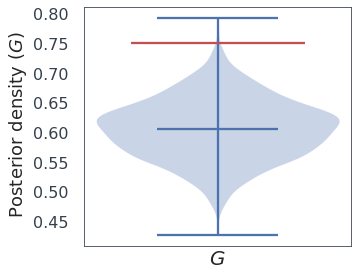

In [229]:
plt.figure(figsize=(5,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.hlines(y=G_true, xmin=0.75, xmax=1.25, colors='r', label='Ground-truth')
#plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior density ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=20); 
plt.xticks([])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_InferredCoupling_obs4.eps"), doi=800)
plt.show()

In [230]:
np.percentile(posterior_samples, [5, 95], axis=0)

array([[ 0.52155615, -0.10222377, -0.10042516, -0.09710639, -0.09738242,
        -0.09830241, -0.09285019, -0.09815911, -0.09340212, -0.10006581,
        -0.09154127, -0.09426099, -0.09639983, -0.0986607 , -0.09222934],
       [ 0.69182441, -0.07204886, -0.00867389, -0.00817059, -0.00863831,
        -0.00612709, -0.00687498, -0.01192491, -0.00883712, -0.00914688,
        -0.0058925 , -0.00950634, -0.00622356, -0.00433986, -0.00760781]])

In [231]:
#np.percentile(posterior_sample, [50], axis=0)
BOLD_fit_ =GenericHopfBOLD(eta_true, omega_true, init_conditions, sigma, G_posterior.mean(), SC,  dt, dt_bold, Tmax, ds)

In [232]:
BOLD_fit=BOLD_fit_.reshape(nn, int(BOLD_fit_.shape[0]/nn))

In [233]:
np.save(os.path.join(Res_dir, 'BOLD_obs4.npy') , BOLD_obs)
np.save(os.path.join(Res_dir, 'BOLD_fit4.npy') , BOLD_fit)

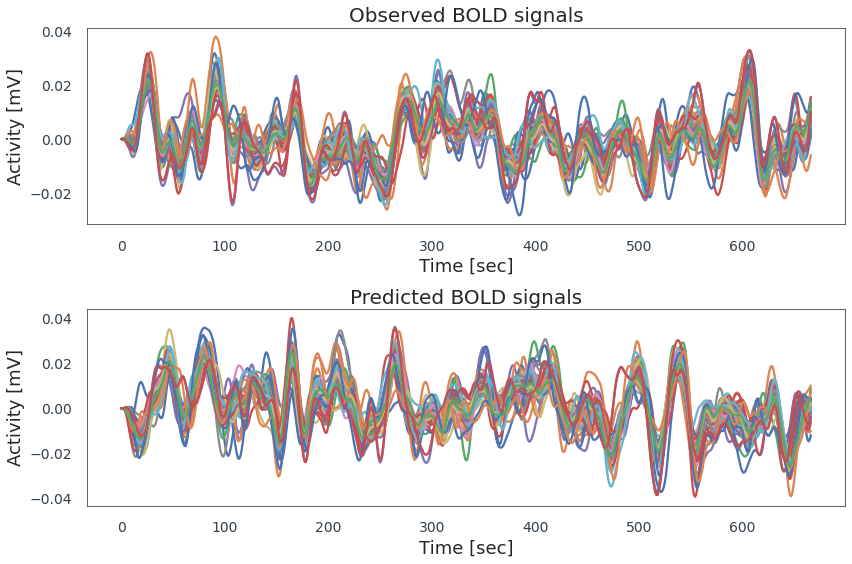

In [234]:
plt.figure(figsize=(12, 8))
plt.subplot(211);
plt.plot(BOLD_obs.T)
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(212)
plt.plot(BOLD_fit.T)
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel('Activity [mV]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsTimeseries_obs4.eps"), doi=800)
plt.show()

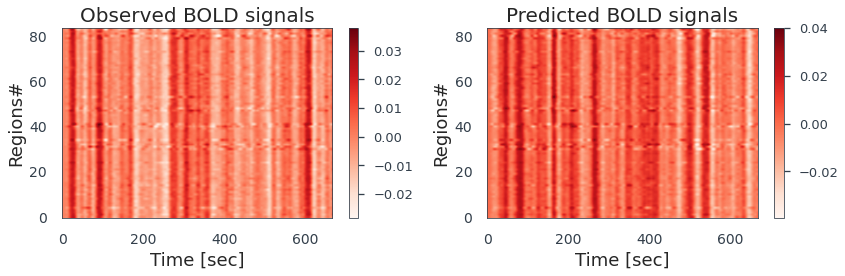

In [235]:
plt.figure(figsize=(12, 4))
plt.subplot(121);
plt.imshow(BOLD_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Observed BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)
plt.imshow(BOLD_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.colorbar();
plt.title("Predicted BOLD signals",fontsize=20)
plt.xlabel('Time [sec]',fontsize=18)
plt.ylabel("Regions#", fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_FittedandobsImshow_obs4.eps"), doi=800)
plt.show()

In [236]:
FCcorr_obs=np.corrcoef(BOLD_obs)
FCcorr_fit=np.corrcoef(BOLD_fit)

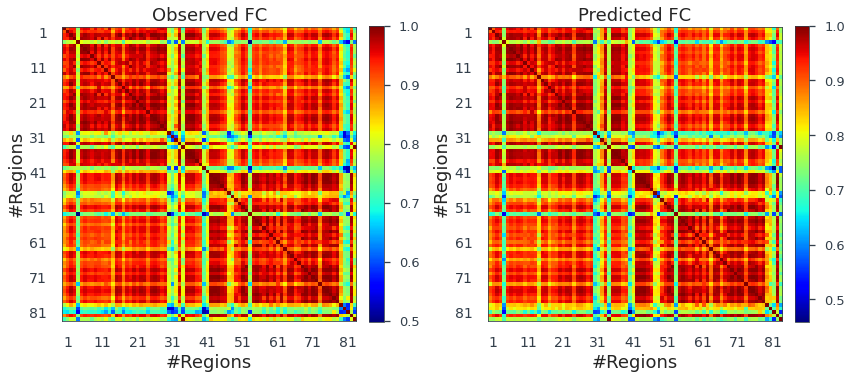

In [237]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FC', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FC_obs4.eps"), doi=800)
plt.show()

In [238]:
FCDcorr_obs,Pcorr_obs,shift_obs=extract_FCD(BOLD_obs,wwidth,maxNwindows,olap,mode='corr')
FCDcorr_fit,Pcorr_fit,shift_fit=extract_FCD(BOLD_fit,wwidth,maxNwindows,olap,mode='corr')

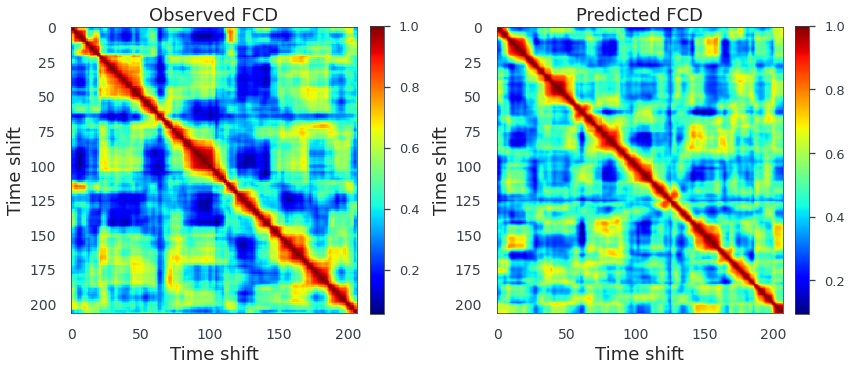

In [239]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((FCDcorr_obs), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Observed FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)


plt.subplot(122)
im = plt.imshow(FCDcorr_fit,cmap=cm.jet)
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title('Predicted FCD', fontsize=18.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time shift', fontsize=18.0)
plt.xlabel('Time shift', fontsize=18.0)

plt.tight_layout()
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.png"), doi=800)
plt.savefig(os.path.join(Res_dir,"SBI_GenericHopf_SimvsPred_FCD_obs4.eps"), doi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


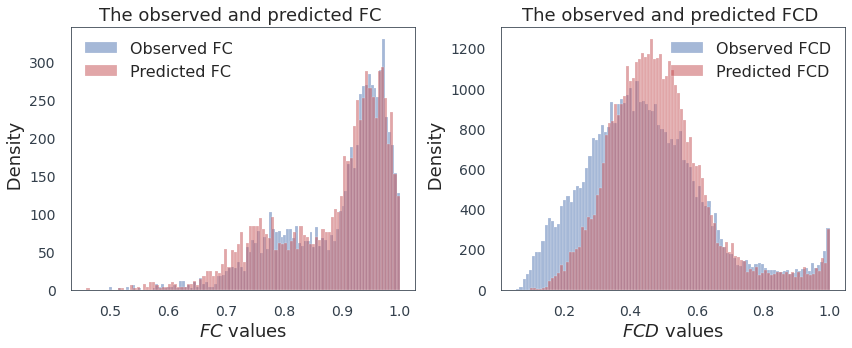

In [240]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(FCcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FC')
plt.hist(FCcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FC')
plt.gca().set_title('The observed and predicted FC ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FC$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)

plt.subplot(122)
plt.hist(FCDcorr_obs.reshape(-1), bins=100, color='b', alpha=0.5, label='Observed FCD')
plt.hist(FCDcorr_fit.reshape(-1), bins=100, color='r', alpha=0.5, label='Predicted FCD')
plt.gca().set_title('The observed and predicted FCD ', fontsize=18.0)
plt.ylabel(' Density',fontsize=18)
plt.xlabel('$FCD$ values',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_GenericHopf_SimvsPred_HistFCFCD_obs4.eps"), doi=800)
plt.show()

In [241]:
sum(FCcorr_obs.reshape(-1))/nn, sum(FCcorr_fit.reshape(-1))/nn

(74.95049235748176, 74.12941005920005)

In [242]:
sum(FCDcorr_obs.reshape(-1))/nn, sum(FCDcorr_fit.reshape(-1))/nn

(228.63807322831377, 248.22985113387625)

In [243]:
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from Similaritymetrics import kl_divergence,  js_divergence
from sklearn.metrics import mutual_info_score

In [244]:
kl_divergence(FCDcorr_obs, FCDcorr_fit), kl_divergence(FCDcorr_fit, FCDcorr_obs)

(-74.82828847546028, 3504.899567465618)

In [245]:
js_divergence(FCDcorr_obs, FCDcorr_fit)

415.29830512724277

In [246]:
wasserstein_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.04272160059929053

In [247]:
energy_distance(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

0.0945133948722176

In [248]:
ks_2samp(FCDcorr_obs.reshape(-1), FCDcorr_fit.reshape(-1))

KstestResult(statistic=0.1473079885178184, pvalue=0.0)